In [2]:
import sys
import numpy as np
from qick.spectrum import SpectrumSoc, DualChain
from qick.fft_helpers import *

import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

In [10]:
# Load bitstream with custom overlay
soc = SpectrumSoc('./spectrum_v1.bit', no_tproc=True)

soccfg=soc
# Print information.
print(soccfg)

QICK running on ZCU111, software version 0.2.325

Firmware configuration (built Tue Aug 26 10:05:29 2025):

	Global clocks (MHz): tProcessor 0.000, RF reference 409.600

SPECTRUM configuration:


	Board: ZCU111
	Analysis 0:
		ADC: 224_0, fs = 4096.0 MHz, Decimation    = 2
		PFB: fs = 256.0 MHz, fc = 128.0 MHz, 16 channels


In [11]:
#########################
### Define dual chain ###
#########################
chain = DualChain(soc,soc['analysis'][0],soc['synthesis'][0])

In [12]:
#Intial config
#PFB quantization
chain.analysis.qout(3)

F1 = 350.001, Y1 = -12.164


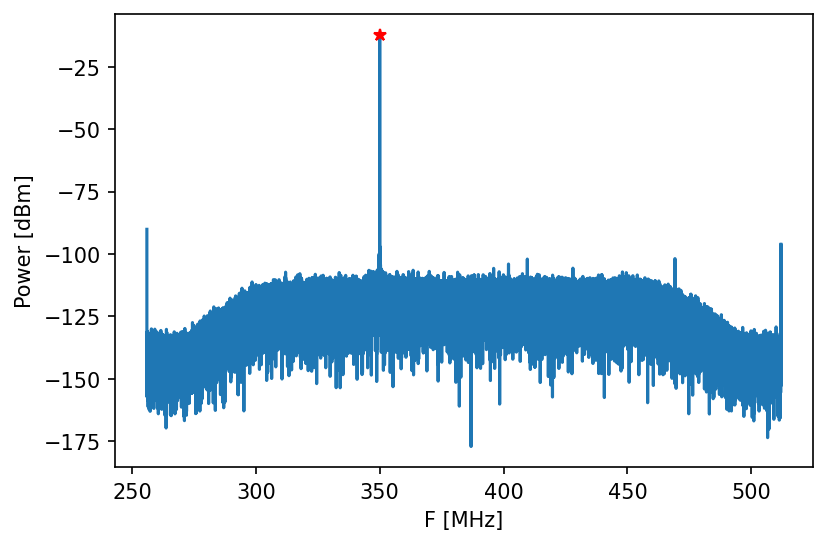

In [13]:
#################################
### Single Channel PFB output ###
#################################
fout = 350
chain.synthesis.set_tone(fout)

# Compute channel center frequency.
FC = chain.analysis.ch2freq(chain.analysis.freq2ch(fout))

# Get data.
[xi,xq] = chain.get_bin_pfb(fout)
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(1,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9
Iteration K = 10
Iteration K = 11
Iteration K = 12
Iteration K = 13
Iteration K = 14
Iteration K = 15


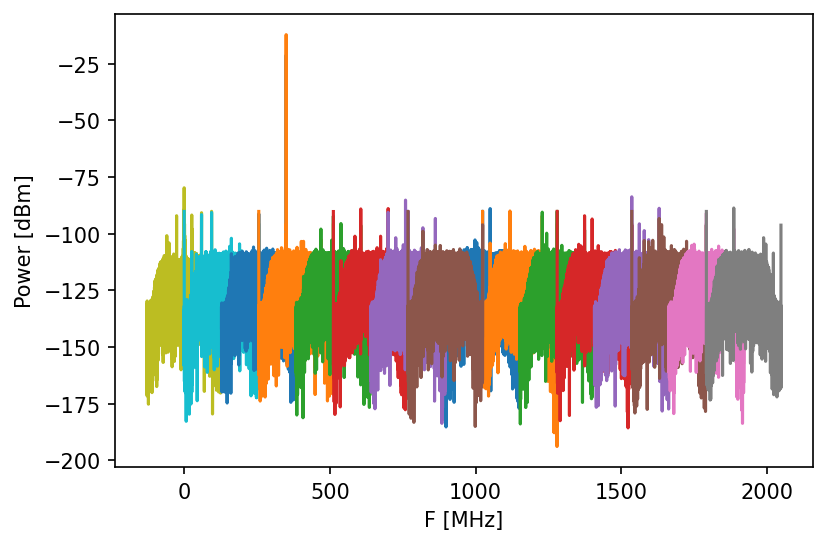

In [14]:
##########################################
### Channels Side-by-Side (PFB output) ###
##########################################
# Channels to plot.
K = np.arange(chain.nch)

plt.figure(1,dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)  
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.
    [xi,xq] = chain.get_bin_pfb(fck+1)
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15

    # Spectrum.
    w = np.hanning(len(x))
    Aw = len(w)/np.sum(w)
    xw = Aw*x*w
    Y = fftshift(fft(xw)/len(xw))
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

F1 = 380.003, Y1 = -12.301
FFT Resolution: 15.625 kHz


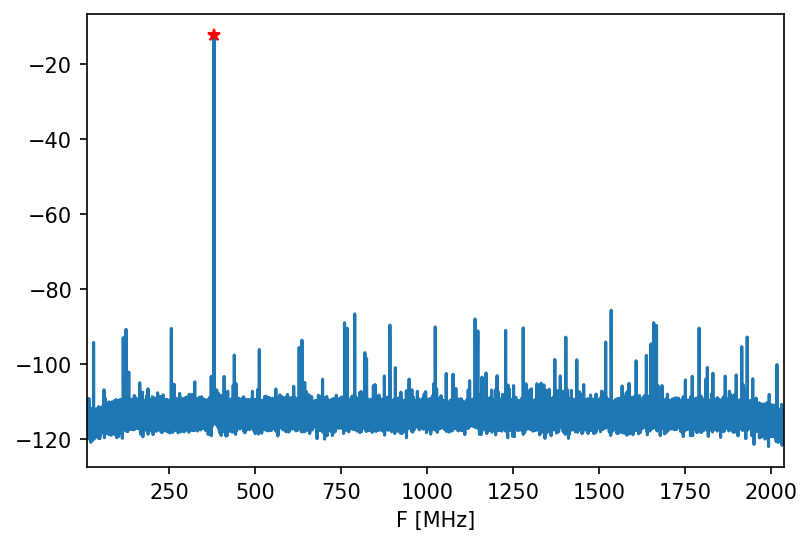

In [15]:
######################################
### Full Bandwidth ACC FULL output ###
######################################
fout = 380
chain.synthesis.set_tone(fout,verbose=True)

# Number of averages.
N = 10

# Get data.
x = chain.get_data_acc(N)

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by FFT length.
x = x/(soc.FFT_N)**2

# Spectrum.
Y = fftshift(x)
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(1,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.xlim([10,2040]);
#plt.ylim([-120,10]);

print('FFT Resolution: {} kHz'.format(1000*soc['analysis'][0]['fs_ch']/soc.FFT_N))

F1 = 256.200, Y1 = -13.626
FFT Resolution: 19.5312 Hz


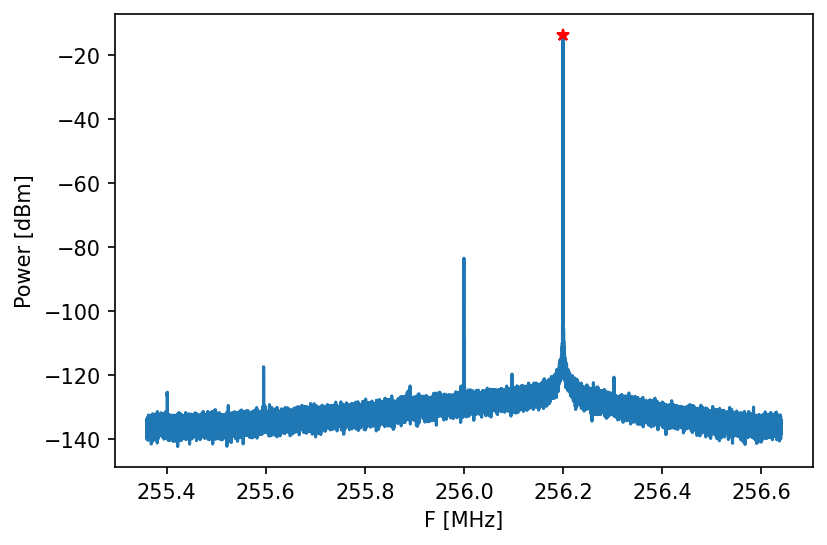

In [23]:
###############################
### Single Channel Zoom FFT ###
###############################
# Output frequency.
fout = 270

chain.synthesis.set_tone(fout)

k=chain.analysis.freq2ch(fout)

# Compute channel center frequency.
FC = chain.analysis.ch2freq(k)

#select PFB channel
soc.chsel.set(k)

# DDS + CIC configuration.
D=200
soc.ddscic.outsel(data="product", cic="yes")
soc.ddscic.decimation(D)
soc.ddscic.ddsfreq(f=14e6-200e3)
soc.ddscic.set_qprod(14) # quantization range for product 0-16


# Get data.
x = chain.get_data_acc_zoom(10)

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by window gain.
x = x*(soc.fft.Aw)**2*(2**16)**2

# Scale by FFT length.
x = x/(soc.acc_zoom.FFT_N)**2

# Sampling frequency.
fs = chain.analysis.dict['chain']['fs_ch']/soc.ddscic.get_decimation()

# Spectrum.
Y = x
F = np.linspace(-fs/2,fs/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

print('FFT Resolution: {:.4f} Hz'.format(1000*1000*fs/soc.acc_zoom.FFT_N))